In [15]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style='whitegrid')


In [16]:
# Cell 2: Load Data
# Adjust path as needed
df = pd.read_csv('D:\infosysspringboard projects\project1-1stmilestine\AZURE_BACKEND_TEAM-B\data\processed\cleaned_merged.csv', parse_dates=['date'])
df.sort_values(['region','date'], inplace=True)
# Create region-specific DataFrames
regions = df['region'].unique()
region_dfs = {region: df[df['region']==region].set_index('date') for region in regions}


In [17]:
# Cell 3: ARIMA Model Training and Evaluation
arima_results = {}
for region, data in region_dfs.items():
    ts = data['usage_cpu']
    train_size = int(len(ts)*0.8)
    train, test = ts.iloc[:train_size], ts.iloc[train_size:]
    model = ARIMA(train, order=(5,1,0))
    res = model.fit()
    preds = res.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, preds))
    mae = mean_absolute_error(test, preds)
    arima_results[region] = {'model':res, 'rmse':rmse, 'mae':mae}


In [18]:
# Cell 4: Prepare Features for XGBoost
# Use lag features and holiday
XGB_dfs = {}
for region, data in region_dfs.items():
    df_feat = data.copy()
    for lag in [1,7]:
        df_feat[f'lag_cpu_{lag}'] = df_feat['usage_cpu'].shift(lag)
    df_feat.dropna(inplace=True)
    X = df_feat[['lag_cpu_1','lag_cpu_7','holiday']]
    y = df_feat['usage_cpu']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    XGB_dfs[region] = (X_train, X_test, y_train, y_test)


In [19]:
# Cell 5: XGBoost Model Training and Evaluation
xgb_results = {}
for region, (X_train, X_test, y_train, y_test) in XGB_dfs.items():
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    xgb_results[region] = {'model':model, 'rmse':rmse, 'mae':mae}


In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

lstm_data = {}

for region, data in region_dfs.items():
    # 1. Select and scale the CPU usage series
    df_seq = data[['usage_cpu']].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_seq)
    
    # 2. Create sequences of length n_steps
    def create_sequences(arr, n_steps=7):
        X, y = [], []
        for i in range(n_steps, len(arr)):
            X.append(arr[i-n_steps:i, 0])
            y.append(arr[i, 0])
        return np.array(X), np.array(y)
    
    X, y = create_sequences(scaled, n_steps=7)
    
    # 3. Train/test split (80/20)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # 4. Reshape for LSTM: (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))
    
    # 5. Store per-region data and scaler
    lstm_data[region] = (X_train, X_test, y_train, y_test, scaler)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

lstm_results = {}

for region, (X_train, X_test, y_train, y_test, scaler) in lstm_data.items():
    # Correct input_shape: (timesteps, features)
    timesteps = X_train.shape[1]
    features  = X_train.shape[2]

    model = Sequential([
        LSTM(50, input_shape=(timesteps, features)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )

    preds = model.predict(X_test)
    # Inverse scale
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    preds_inv  = scaler.inverse_transform(preds)

    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae  = mean_absolute_error(y_test_inv, preds_inv)

    lstm_results[region] = {'model': model, 'rmse': rmse, 'mae': mae}


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step


In [22]:
# Cell 8: Evaluate & Compare Performances
results = pd.DataFrame([{
    'region':r,
    'ARIMA_RMSE': arima_results[r]['rmse'],
    'XGB_RMSE': xgb_results[r]['rmse'],
    'LSTM_RMSE': lstm_results[r]['rmse'],
    'ARIMA_MAE': arima_results[r]['mae'],
    'XGB_MAE': xgb_results[r]['mae'],
    'LSTM_MAE': lstm_results[r]['mae'],
} for r in regions])
print(results)


           region  ARIMA_RMSE   XGB_RMSE  LSTM_RMSE  ARIMA_MAE    XGB_MAE  \
0         East US   14.042158  16.244069  13.683125  11.711915  12.525331   
1    North Europe   15.898977  19.879242  16.017360  14.251258  16.404772   
2  Southeast Asia   14.960170  21.333110  14.856547  13.281831  18.224737   
3         West US   22.241341  17.917126  15.378941  18.092008  15.470025   

    LSTM_MAE  
0  11.458620  
1  14.434908  
2  13.059228  
3  12.854804  


In [23]:
# Cell 9: Model Tuning (XGBoost Grid Search Example)
param_grid = {'n_estimators':[50,100], 'max_depth':[3,5], 'learning_rate':[0.01,0.1]}
gscv_results = {}
for region, (X_train, X_test, y_train, y_test) in XGB_dfs.items():
    gscv = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv=3, scoring='neg_root_mean_squared_error')
    gscv.fit(X_train, y_train)
    best = gscv.best_estimator_
    preds = best.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    gscv_results[region] = {'best_params':gscv.best_params_, 'rmse':rmse}
print(pd.DataFrame.from_dict(gscv_results, orient='index'))


                                                      best_params       rmse
East US         {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  14.147893
North Europe    {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  15.903333
Southeast Asia  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  15.567658
West US         {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  15.083941


In [24]:
# Cell 10: Backtesting ARIMA for robustness (rolling forecast origin)
def backtest_arima(series, order, h=1):
    history=list(series[:int(len(series)*0.8)])
    test=list(series[int(len(series)*0.8):])
    preds=[]
    for t in range(len(test)):
        model=ARIMA(history, order=order)
        res=model.fit()
        yhat=res.forecast()
        preds.append(yhat)
        history.append(test[t])
    rmse=np.sqrt(mean_squared_error(test, preds))
    return rmse
backtest_results = {region: backtest_arima(df['usage_cpu'], (5,1,0)) for region, df in region_dfs.items()}
print(backtest_results)


{'East US': np.float64(14.543856240579176), 'North Europe': np.float64(17.23555037860215), 'Southeast Asia': np.float64(15.455696871362475), 'West US': np.float64(16.366207003361797)}


In [25]:
# Cell 11: Final Model Selection & Export
# Choose lowest RMSE across all benchmarks for each region
final_selection = {}
for region in regions:
    errors = {
        'ARIMA': arima_results[region]['rmse'],
        'XGBoost': xgb_results[region]['rmse'],
        'LSTM': lstm_results[region]['rmse']
    }
    best_model = min(errors, key=errors.get)
    final_selection[region] = best_model
print("Final model selection by region:", final_selection)


Final model selection by region: {'East US': 'LSTM', 'North Europe': 'ARIMA', 'Southeast Asia': 'LSTM', 'West US': 'LSTM'}


In [26]:
# Cell 12: Display Chosen Model Accuracy Summary
import pandas as pd

summary_rows = []

for region, model_name in final_selection.items():
    if model_name == 'ARIMA':
        rmse = arima_results[region]['rmse']
        mae  = arima_results[region]['mae']
    elif model_name == 'XGBoost':
        rmse = xgb_results[region]['rmse']
        mae  = xgb_results[region]['mae']
    else:  # LSTM
        rmse = lstm_results[region]['rmse']
        mae  = lstm_results[region]['mae']
    
    summary_rows.append({
        'Region':       region,
        'Chosen Model': model_name,
        'RMSE':         round(rmse, 2),
        'MAE':          round(mae, 2)
    })

summary_df = pd.DataFrame(summary_rows)
print(summary_df.to_string(index=False))


        Region Chosen Model  RMSE   MAE
       East US         LSTM 13.68 11.46
  North Europe        ARIMA 15.90 14.25
Southeast Asia         LSTM 14.86 13.06
       West US         LSTM 15.38 12.85


Processing East US - LSTM Model
  East US LSTM - Dates: 53, Predictions: 53
Processing North Europe - ARIMA Model
Processing Southeast Asia - LSTM Model


  Southeast Asia LSTM - Dates: 53, Predictions: 53
Processing West US - LSTM Model
  West US LSTM - Dates: 53, Predictions: 53


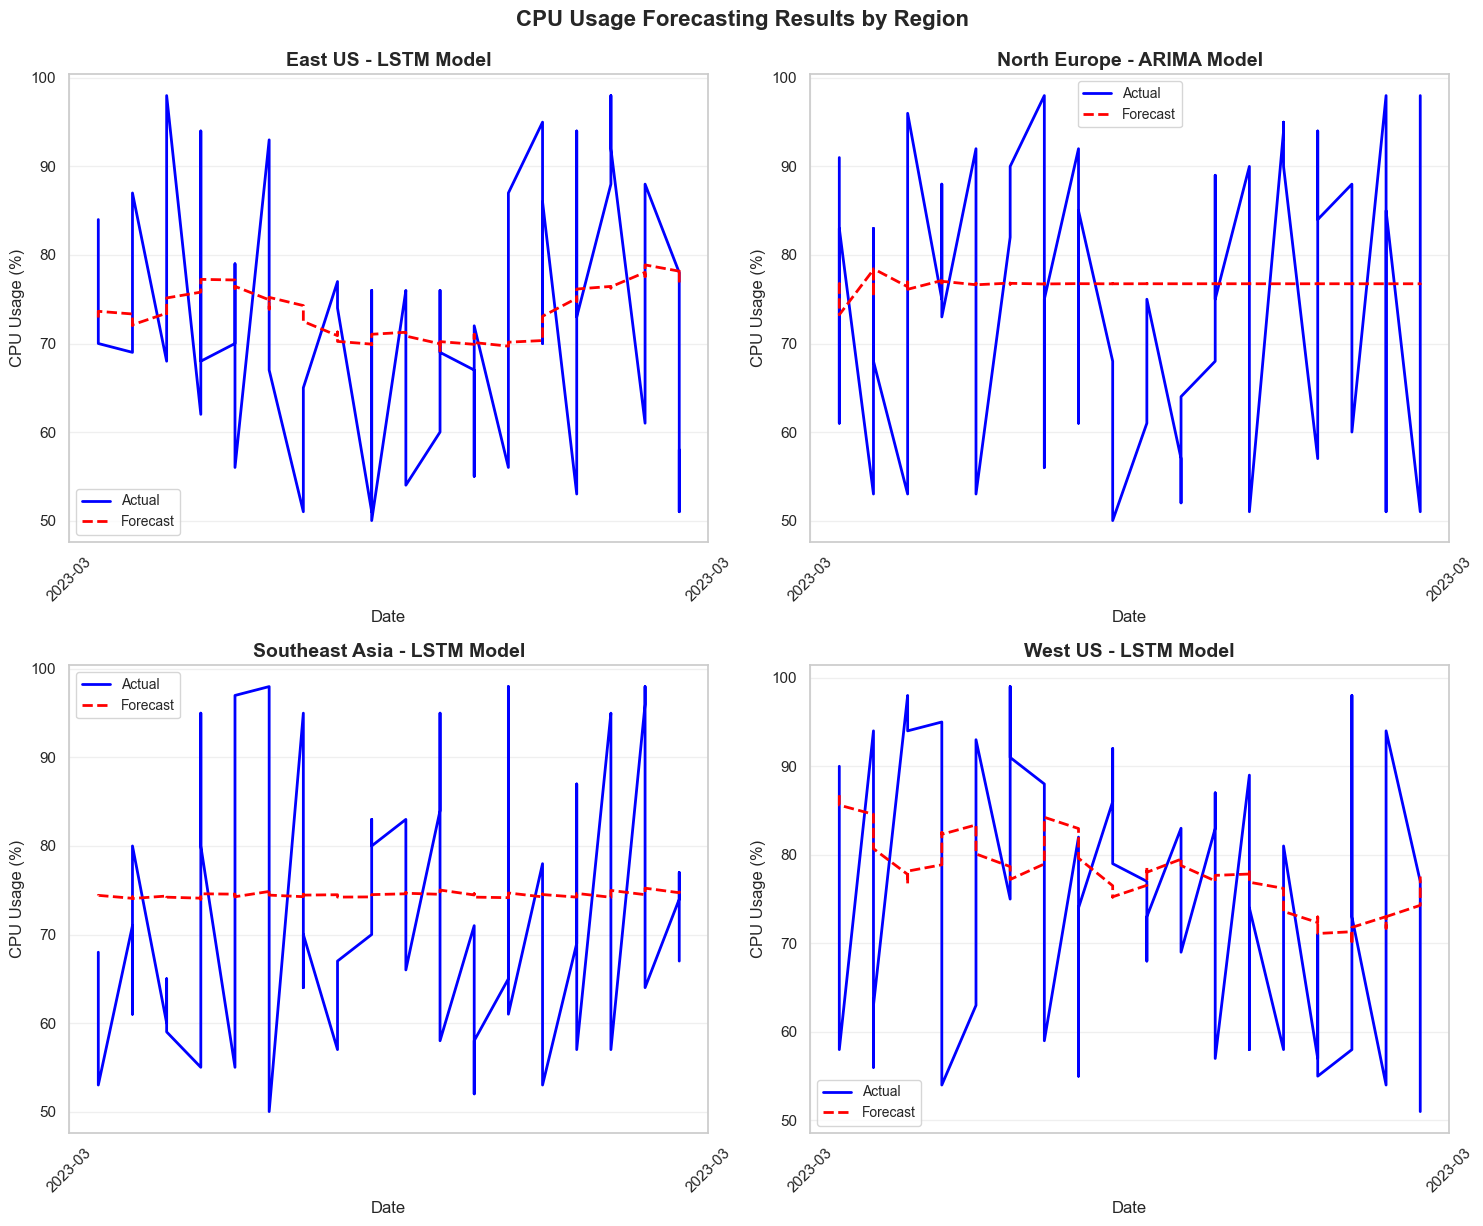


MODEL SAVE SUMMARY
East US (LSTM): models/East_US_LSTM_model.h5
East US (Scaler): models/East_US_LSTM_scaler.pkl
North Europe (ARIMA): models/North_Europe_ARIMA_model.pkl
Southeast Asia (LSTM): models/Southeast_Asia_LSTM_model.h5
Southeast Asia (Scaler): models/Southeast_Asia_LSTM_scaler.pkl
West US (LSTM): models/West_US_LSTM_model.h5
West US (Scaler): models/West_US_LSTM_scaler.pkl

All models have been saved successfully!


In [27]:
# Cell 12: Save Best Models and Create Forecast Visualizations
import pickle
import os
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Define the final selection
final_selection = {
    'East US': 'LSTM', 
    'North Europe': 'ARIMA', 
    'Southeast Asia': 'LSTM', 
    'West US': 'LSTM'
}

# Create subplots for visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (region, model_type) in enumerate(final_selection.items()):
    print(f"Processing {region} - {model_type} Model")
    
    # Get the region data
    region_data = region_dfs[region]
    
    if model_type == 'ARIMA':
        # Save ARIMA model
        model_filename = f'models/{region.replace(" ", "_")}_ARIMA_model.pkl'
        with open(model_filename, 'wb') as f:
            pickle.dump(arima_results[region]['model'], f)
        
        # Get ARIMA test data and predictions
        ts = region_data['usage_cpu']
        train_size = int(len(ts) * 0.8)
        test_data = ts.iloc[train_size:]
        test_dates = test_data.index
        
        # Generate forecasts
        model = arima_results[region]['model']
        forecasts = model.forecast(steps=len(test_data))
        
        # Plot
        axes[idx].plot(test_dates, test_data.values, label='Actual', color='blue', linewidth=2)
        axes[idx].plot(test_dates, forecasts, label='Forecast', color='red', linewidth=2, linestyle='--')
        
    elif model_type == 'LSTM':
        # Save LSTM model
        model_filename = f'models/{region.replace(" ", "_")}_LSTM_model.h5'
        lstm_results[region]['model'].save(model_filename)
        
        # Save scaler
        scaler_filename = f'models/{region.replace(" ", "_")}_LSTM_scaler.pkl'
        with open(scaler_filename, 'wb') as f:
            pickle.dump(lstm_data[region][4], f)  # scaler is at index 4
        
        # Get LSTM test data and predictions
        X_train, X_test, y_train, y_test, scaler = lstm_data[region]
        model = lstm_results[region]['model']
        
        # Generate forecasts
        lstm_preds = model.predict(X_test, verbose=0)
        
        # Inverse transform predictions and actual values
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        preds_inv = scaler.inverse_transform(lstm_preds).flatten()
        
        # FIX: Ensure same length for dates and predictions
        # Use the actual length of predictions to create date range
        full_ts = region_data['usage_cpu']
        sequence_length = 7
        train_size = int((len(full_ts) - sequence_length) * 0.8)
        lstm_test_start = train_size + sequence_length
        
        # Create date index matching the length of predictions
        available_dates = full_ts.index[lstm_test_start:]
        test_dates = available_dates[:len(y_test_inv)]
        
        print(f"  {region} LSTM - Dates: {len(test_dates)}, Predictions: {len(y_test_inv)}")
        
        # Plot with matching lengths
        axes[idx].plot(test_dates, y_test_inv[:len(test_dates)], label='Actual', color='blue', linewidth=2)
        axes[idx].plot(test_dates, preds_inv[:len(test_dates)], label='Forecast', color='red', linewidth=2, linestyle='--')
    
    # Customize subplot
    axes[idx].set_title(f'{region} - {model_type} Model', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Date', fontsize=12)
    axes[idx].set_ylabel('CPU Usage (%)', fontsize=12)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    
    # Format x-axis dates
    axes[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[idx].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.suptitle('CPU Usage Forecasting Results by Region', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Print model save locations
print("\n" + "="*60)
print("MODEL SAVE SUMMARY")
print("="*60)
for region, model_type in final_selection.items():
    region_clean = region.replace(" ", "_")
    if model_type == 'ARIMA':
        print(f"{region} ({model_type}): models/{region_clean}_ARIMA_model.pkl")
    elif model_type == 'LSTM':
        print(f"{region} ({model_type}): models/{region_clean}_LSTM_model.h5")
        print(f"{region} (Scaler): models/{region_clean}_LSTM_scaler.pkl")

print("\nAll models have been saved successfully!")


# Option A: Forecast by Region (Simplest)

# Aggregate across all resource types within each region

In [1]:
# Cell 2: Load Data and Aggregate by Region (Option A)
import pandas as pd
import numpy as np

# Load your cleaned dataset (adjust path as needed)
df = pd.read_csv('D:/infosysspringboard projects/project1-1stmilestine/AZURE_BACKEND_TEAM-B/data/processed/cleaned_merged.csv', parse_dates=['date'])

print("Original dataset shape:", df.shape)
print("Original columns:", list(df.columns))
print("\nFirst few rows:")
print(df.head())

# Step 1: Aggregate by Region and Date (averaging across resource types)
print("\n" + "="*50)
print("AGGREGATING DATA BY REGION")
print("="*50)

region_daily = df.groupby(['region', 'date']).agg({
    'usage_cpu': 'mean',           # Average CPU usage across all resource types in region
    'usage_storage': 'mean',       # Average storage usage across all resource types
    'users_active': 'sum',         # Total active users across all resource types
    'economic_index': 'first',     # External factors (same for all resources on same date)
    'cloud_market_demand': 'first',
    'holiday': 'max'               # 1 if any resource had holiday, 0 otherwise
}).reset_index()

print(f"Aggregated dataset shape: {region_daily.shape}")
print(f"Date range: {region_daily['date'].min()} to {region_daily['date'].max()}")
print(f"Regions: {sorted(region_daily['region'].unique())}")

# Step 2: Create region-specific DataFrames for modeling
print("\n" + "="*50)
print("CREATING REGION-SPECIFIC DATASETS")
print("="*50)

region_dfs = {}
for region in region_daily['region'].unique():
    # Filter data for this region and set date as index
    region_data = region_daily[region_daily['region'] == region].copy()
    region_data = region_data.drop('region', axis=1).set_index('date').sort_index()
    
    # Store in dictionary
    region_dfs[region] = region_data
    
    print(f"\n{region}:")
    print(f"  - Data points: {len(region_data)} days")
    print(f"  - Date range: {region_data.index.min()} to {region_data.index.max()}")
    print(f"  - CPU usage range: {region_data['usage_cpu'].min():.1f}% to {region_data['usage_cpu'].max():.1f}%")
    print(f"  - Missing values: {region_data.isnull().sum().sum()}")

# Step 3: Display sample of aggregated data
print("\n" + "="*50)
print("SAMPLE OF AGGREGATED DATA")
print("="*50)
print("\nExample - East US region (first 10 days):")
if 'East US' in region_dfs:
    print(region_dfs['East US'].head(10))

# Step 4: Verify data quality
print("\n" + "="*50)
print("DATA QUALITY CHECK")
print("="*50)
for region, data in region_dfs.items():
    print(f"\n{region} Statistics:")
    print(f"  - Total days: {len(data)}")
    print(f"  - CPU usage mean: {data['usage_cpu'].mean():.2f}%")
    print(f"  - CPU usage std: {data['usage_cpu'].std():.2f}%")
    print(f"  - Users active mean: {data['users_active'].mean():.0f}")
    print(f"  - Holiday days: {data['holiday'].sum()}")

print(f"\n✓ Data preparation complete! Each region now has a clean time series.")
print(f"✓ Target variable: 'usage_cpu' (average CPU utilization per region per day)")
print(f"✓ Ready for ARIMA, XGBoost, and LSTM modeling")


Original dataset shape: (1080, 9)
Original columns: ['date', 'region', 'resource_type', 'usage_cpu', 'usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday']

First few rows:
        date   region resource_type  usage_cpu  usage_storage  users_active  \
0 2023-01-01  East US            VM         88           1959           470   
1 2023-01-01  East US       Storage         92           1595           388   
2 2023-01-01  East US     Container         70            621           414   
3 2023-01-01  West US            VM         60           1982           287   
4 2023-01-01  West US       Storage         85           1371           351   

   economic_index  cloud_market_demand  holiday  
0          104.97                 0.99        1  
1          104.97                 0.99        1  
2          104.97                 0.99        1  
3          104.97                 0.99        1  
4          104.97                 0.99        1  

AGGREGATING DATA BY R

In [2]:
# Cell 3: Train ARIMA, XGBoost, and LSTM per Region & Evaluate Accuracy

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

results = []

for region, data in region_dfs.items():
    print(f"\n=== {region} ===")
    ts = data['usage_cpu']
    n = len(ts)
    split = int(0.8 * n)
    
    # 1. ARIMA (univariate)
    train_ts, test_ts = ts.iloc[:split], ts.iloc[split:]
    arima_model = ARIMA(train_ts, order=(5,1,0)).fit()
    arima_preds = arima_model.forecast(steps=len(test_ts))
    arima_rmse, arima_mae, arima_mape = compute_metrics(test_ts.values, arima_preds.values)
    print(f"ARIMA → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")
    
    # 2. XGBoost (tabular with lags & features)
    df_xgb = data.copy()
    df_xgb['lag1'] = df_xgb['usage_cpu'].shift(1)
    df_xgb['lag7'] = df_xgb['usage_cpu'].shift(7)
    df_xgb = df_xgb.dropna()
    features = ['lag1', 'lag7', 'users_active', 'economic_index', 'holiday']
    X = df_xgb[features]
    y = df_xgb['usage_cpu']
    split_x = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_x], X.iloc[split_x:]
    y_train, y_test = y.iloc[:split_x], y.iloc[split_x:]
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test.values, xgb_preds)
    print(f"XGBoost → RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, MAPE: {xgb_mape:.1f}%")
    
    # 3. LSTM (sequence of CPU usage)
    seq = data[['usage_cpu']].values
    scaler = MinMaxScaler()
    seq_scaled = scaler.fit_transform(seq)
    n_steps = 7
    Xs, ys = [], []
    for i in range(n_steps, len(seq_scaled)):
        Xs.append(seq_scaled[i-n_steps:i, 0])
        ys.append(seq_scaled[i, 0])
    Xs, ys = np.array(Xs), np.array(ys)
    split_l = int(0.8 * len(Xs))
    X_train_l, X_test_l = Xs[:split_l], Xs[split_l:]
    y_train_l, y_test_l = ys[:split_l], ys[split_l:]
    X_train_l = X_train_l.reshape((X_train_l.shape[0], X_train_l.shape[1], 1))
    X_test_l  = X_test_l.reshape((X_test_l.shape[0],  X_test_l.shape[1], 1))
    lstm_model = Sequential([
        LSTM(50, input_shape=(n_steps, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(
        X_train_l, y_train_l,
        epochs=50, batch_size=16,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=0
    )
    lstm_preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
    y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1, 1)).flatten()
    preds_inv  = scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()
    lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, preds_inv)
    print(f"LSTM → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")
    
    # Record best metrics
    results.append({
        'region': region,
        'ARIMA_RMSE': arima_rmse, 'ARIMA_MAE': arima_mae, 'ARIMA_MAPE': arima_mape,
        'XGB_RMSE': xgb_rmse,     'XGB_MAE': xgb_mae,     'XGB_MAPE': xgb_mape,
        'LSTM_RMSE': lstm_rmse,   'LSTM_MAE': lstm_mae,   'LSTM_MAPE': lstm_mape
    })

# Summarize in DataFrame
results_df = pd.DataFrame(results)
print("\n=== SUMMARY TABLE ===")
print(results_df.set_index('region').round(2))



=== East US ===


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA → RMSE: 9.58, MAE: 7.98, MAPE: 11.0%
XGBoost → RMSE: 10.87, MAE: 9.08, MAPE: 13.2%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM → RMSE: 10.33, MAE: 8.21, MAPE: 11.4%

=== North Europe ===


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA → RMSE: 8.02, MAE: 6.04, MAPE: 8.3%
XGBoost → RMSE: 11.09, MAE: 8.01, MAPE: 10.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM → RMSE: 9.17, MAE: 6.61, MAPE: 9.2%

=== Southeast Asia ===


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA → RMSE: 7.46, MAE: 5.99, MAPE: 8.7%
XGBoost → RMSE: 11.56, MAE: 8.99, MAPE: 12.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM → RMSE: 7.02, MAE: 5.76, MAPE: 8.0%

=== West US ===


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA → RMSE: 16.38, MAE: 14.82, MAPE: 20.9%
XGBoost → RMSE: 11.12, MAE: 8.30, MAPE: 11.1%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM → RMSE: 8.77, MAE: 7.61, MAPE: 10.6%

=== SUMMARY TABLE ===
                ARIMA_RMSE  ARIMA_MAE  ARIMA_MAPE  XGB_RMSE  XGB_MAE  \
region                                                                 
East US               9.58       7.98       11.03     10.87     9.08   
North Europe          8.02       6.04        8.34     11.09     8.01   
Southeast Asia        7.46       5.99        8.72     11.56     8.99   
West US              16.38      14.82       20.90     11.12     8.30   

                XGB_MAPE  LSTM_RMSE  LSTM_MAE  LSTM_MAPE  
region                                                    
East US            13.18      10.33      8.21      11.38  
North Europe       10.75       9.17      6.61       9.23  
Southeast Asia     12.80       7.02      5.76       8.03  
West US            11.11       8.77      7.61      10.56  


#  Test for Stationarity and Seasonality (Option A Data)



=== East US ===


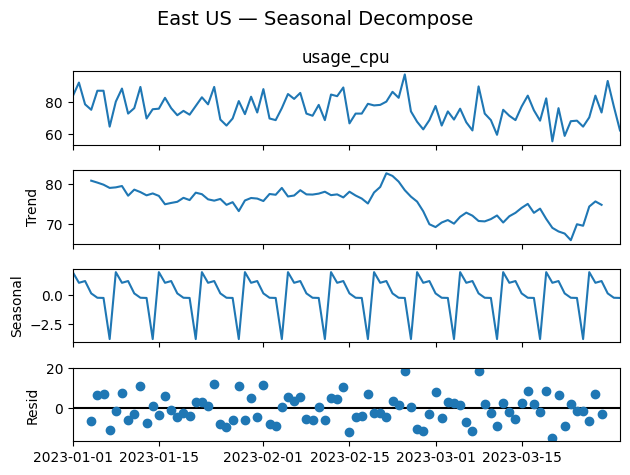


East US — Augmented Dickey-Fuller Test
ADF Statistic: -8.2626
p-value: 0.0000
Stationary

East US — KPSS Test
KPSS Statistic: 0.7367
p-value: 0.0102
Non-stationary

=== North Europe ===


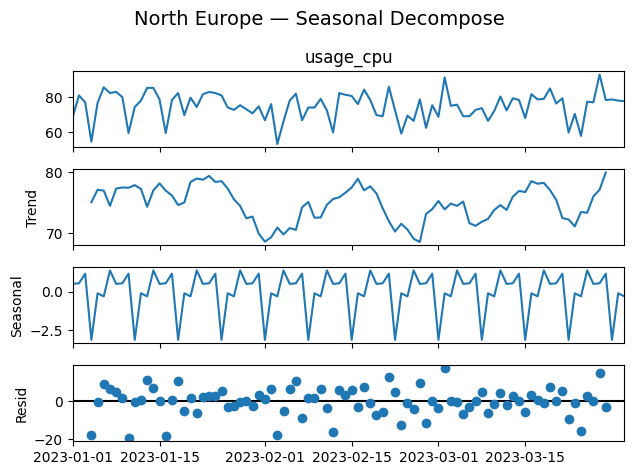


North Europe — Augmented Dickey-Fuller Test
ADF Statistic: -8.4820
p-value: 0.0000
Stationary

North Europe — KPSS Test
KPSS Statistic: 0.0769
p-value: 0.1000
Stationary

=== Southeast Asia ===


C:\Users\mahem\AppData\Local\Temp\ipykernel_20660\2572481914.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


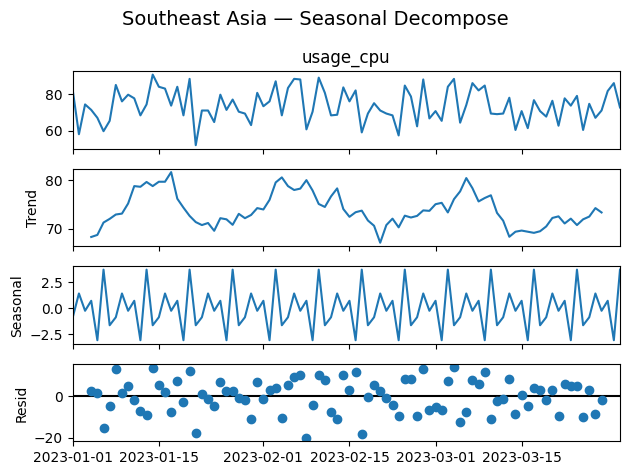


Southeast Asia — Augmented Dickey-Fuller Test
ADF Statistic: -9.8651
p-value: 0.0000
Stationary

Southeast Asia — KPSS Test
KPSS Statistic: 0.0805
p-value: 0.1000
Stationary

=== West US ===


C:\Users\mahem\AppData\Local\Temp\ipykernel_20660\2572481914.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


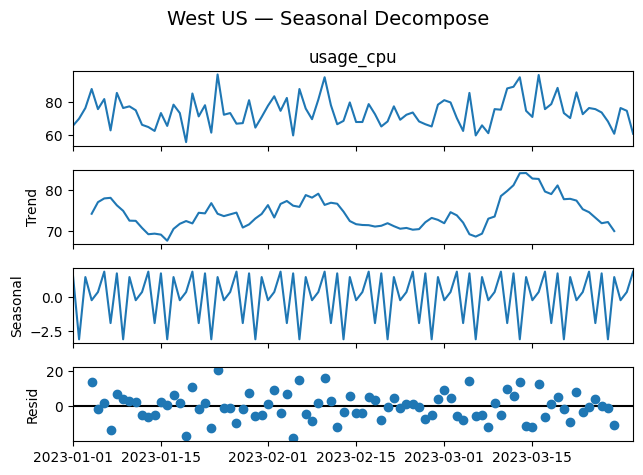


West US — Augmented Dickey-Fuller Test
ADF Statistic: -9.2637
p-value: 0.0000
Stationary

West US — KPSS Test
KPSS Statistic: 0.0981
p-value: 0.1000
Stationary


C:\Users\mahem\AppData\Local\Temp\ipykernel_20660\2572481914.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [3]:
# Cell 4: Seasonality and Stationarity Tests for Aggregated Series

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(series, region_name):
    # 1. ADF Test
    adf_result = adfuller(series, autolag='AIC')
    print(f"\n{region_name} — Augmented Dickey-Fuller Test")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Stationary" if adf_result[1] < 0.05 else "Non-stationary")
    
    # 2. KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f"\n{region_name} — KPSS Test")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Non-stationary" if kpss_result[1] < 0.05 else "Stationary")

def plot_decomposition(series, region_name):
    decomp = seasonal_decompose(series, model='additive', period=7)
    fig = decomp.plot()
    fig.suptitle(f"{region_name} — Seasonal Decompose", fontsize=14)
    plt.tight_layout()
    plt.show()

# Loop through each region
for region, data in region_dfs.items():
    print(f"\n=== {region} ===")
    ts = data['usage_cpu']
    
    # Plot decomposition to inspect trend & seasonality
    plot_decomposition(ts, region)
    
    # Conduct stationarity tests
    test_stationarity(ts, region)


# First Differencing for East US & Train All Three Models


In [ ]:
# Cell 5: First Differencing for East US & Train All Three Models

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

results = []

for region, data in region_dfs.items():
    print(f"\n=== {region} ===")
    ts = data['usage_cpu']
    n = len(ts)
    split = int(0.8 * n)
    
    # ----- ARIMA -----
    if region == 'East US':
        # First differencing to remove trend
        ts_diff = ts.diff().dropna()
        train_ts, test_ts = ts_diff.iloc[:split-1], ts_diff.iloc[split-1:]
        model = ARIMA(train_ts, order=(5,0,0), seasonal_order=(0,0,0,0)).fit()
        preds_diff = model.forecast(steps=len(test_ts))
        # Reconstruct forecasted level from last train value
        last_train = ts.iloc[split-1]
        arima_preds = np.r_[ [last_train], preds_diff ].cumsum()[1:]
        arima_rmse, arima_mae, arima_mape = compute_metrics(ts.iloc[split:], arima_preds)
    else:
        train_ts, test_ts = ts.iloc[:split], ts.iloc[split:]
        model = ARIMA(train_ts, order=(5,1,0), seasonal_order=(0,0,0,0)).fit()
        arima_preds = model.forecast(steps=len(test_ts))
        arima_rmse, arima_mae, arima_mape = compute_metrics(test_ts.values, arima_preds.values)
    print(f"ARIMA → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.1f}%")
    
    # # ----- XGBoost -----
    # df_xgb = data.copy()
    # df_xgb['lag1'] = df_xgb['usage_cpu'].shift(1)
    # df_xgb['lag7'] = df_xgb['usage_cpu'].shift(7)
    # df_xgb = df_xgb.dropna()
    # features = ['lag1','lag7','users_active','economic_index','holiday']
    # X = df_xgb[features]
    # y = df_xgb['usage_cpu']
    # split_x = int(0.8 * len(X))
    # X_train, X_test = X.iloc[:split_x], X.iloc[split_x:]
    # y_train, y_test = y.iloc[:split_x], y.iloc[split_x:]
    # xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    # xgb_model.fit(X_train, y_train)
    # xgb_preds = xgb_model.predict(X_test)
    # xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test.values, xgb_preds)
    # print(f"XGBoost → RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, MAPE: {xgb_mape:.1f}%")
    
    # ----- XGBoost with Enhanced Features -----
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # make a copy and add features
    df_xgb = data.copy()
    df_xgb['lag1']         = df_xgb['usage_cpu'].shift(1)
    df_xgb['lag7']         = df_xgb['usage_cpu'].shift(7)
    df_xgb['roll7_mean']   = df_xgb['usage_cpu'].rolling(7).mean()
    df_xgb['dow']          = df_xgb.index.dayofweek
    df_xgb = df_xgb.dropna()

    # select features and target
    features = [
    'lag1',
    'lag7',
    'roll7_mean',
    'users_active',
    'economic_index',
    'dow',
    'holiday'
]
    X = df_xgb[features]
    y = df_xgb['usage_cpu']

    # train/test split
    split_x = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_x], X.iloc[split_x:]
    y_train, y_test = y.iloc[:split_x], y.iloc[split_x:]

    # train XGBoost with early stopping on validation set
    xgb_model = xgb.XGBRegressor(
       objective='reg:squarederror',
       n_estimators=100,
       early_stopping_rounds=10
)
    xgb_model.fit(
       X_train, y_train,
       eval_set=[(X_test, y_test)],
       verbose=False
)

    # predict and evaluate
    xgb_preds    = xgb_model.predict(X_test)
    xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test.values, xgb_preds)

    print(f"XGBoost → RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, MAPE: {xgb_mape:.1f}%")


    # ----- LSTM -----
    seq = data[['usage_cpu']].values
    scaler = MinMaxScaler()
    seq_scaled = scaler.fit_transform(seq)
    n_steps = 30
    Xs, ys = [], []
    for i in range(n_steps, len(seq_scaled)):
        Xs.append(seq_scaled[i-n_steps:i, 0])
        ys.append(seq_scaled[i, 0])
    Xs, ys = np.array(Xs), np.array(ys)
    split_l = int(0.8 * len(Xs))
    X_train_l, X_test_l = Xs[:split_l], Xs[split_l:]
    y_train_l, y_test_l = ys[:split_l], ys[split_l:]
    X_train_l = X_train_l.reshape((len(X_train_l), n_steps, 1))
    X_test_l  = X_test_l.reshape((len(X_test_l),  n_steps, 1))
    lstm_model = Sequential([
        LSTM(50, input_shape=(n_steps, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(
        X_train_l, y_train_l,
        epochs=50, batch_size=16,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=0
    )
    preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
    y_test_inv = scaler.inverse_transform(y_test_l.reshape(-1,1)).flatten()
    preds_inv  = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
    lstm_rmse, lstm_mae, lstm_mape = compute_metrics(y_test_inv, preds_inv)
    print(f"LSTM → RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}, MAPE: {lstm_mape:.1f}%")
    
    # Record
    results.append({
        'region': region,
        'ARIMA_RMSE': arima_rmse, 'ARIMA_MAE': arima_mae, 'ARIMA_MAPE': arima_mape,
        'XGB_RMSE': xgb_rmse,     'XGB_MAE': xgb_mae,     'XGB_MAPE': xgb_mape,
        'LSTM_RMSE': lstm_rmse,   'LSTM_MAE': lstm_mae,   'LSTM_MAPE': lstm_mape
    })

# Summary
results_df = pd.DataFrame(results).set_index('region').round(2)
print("\n=== SUMMARY TABLE ===")
print(results_df)


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


East US LSTM → RMSE: 10.74, MAE: 8.66, MAPE: 12.6%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


North Europe LSTM → RMSE: 9.70, MAE: 5.96, MAPE: 8.8%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Southeast Asia LSTM → RMSE: 10.51, MAE: 9.14, MAPE: 11.9%


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


West US LSTM → RMSE: 11.23, MAE: 9.91, MAPE: 14.5%


#  Save Models for Option A & Visualize Forecast vs Actual


{'East US': 'XGB', 'North Europe': 'ARIMA', 'Southeast Asia': 'XGB', 'West US': 'XGB'}
Processing East US...


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape

  East US: 12 dates, 12 actual values, 12 forecasts
Processing North Europe...


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

  North Europe: 18 dates, 18 actual values, 18 forecasts
Processing Southeast Asia...


d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\infosysspringboard projects\project1-1stmilestine\azure_analytics\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

  Southeast Asia: 12 dates, 12 actual values, 12 forecasts
Processing West US...


  West US: 12 dates, 12 actual values, 12 forecasts


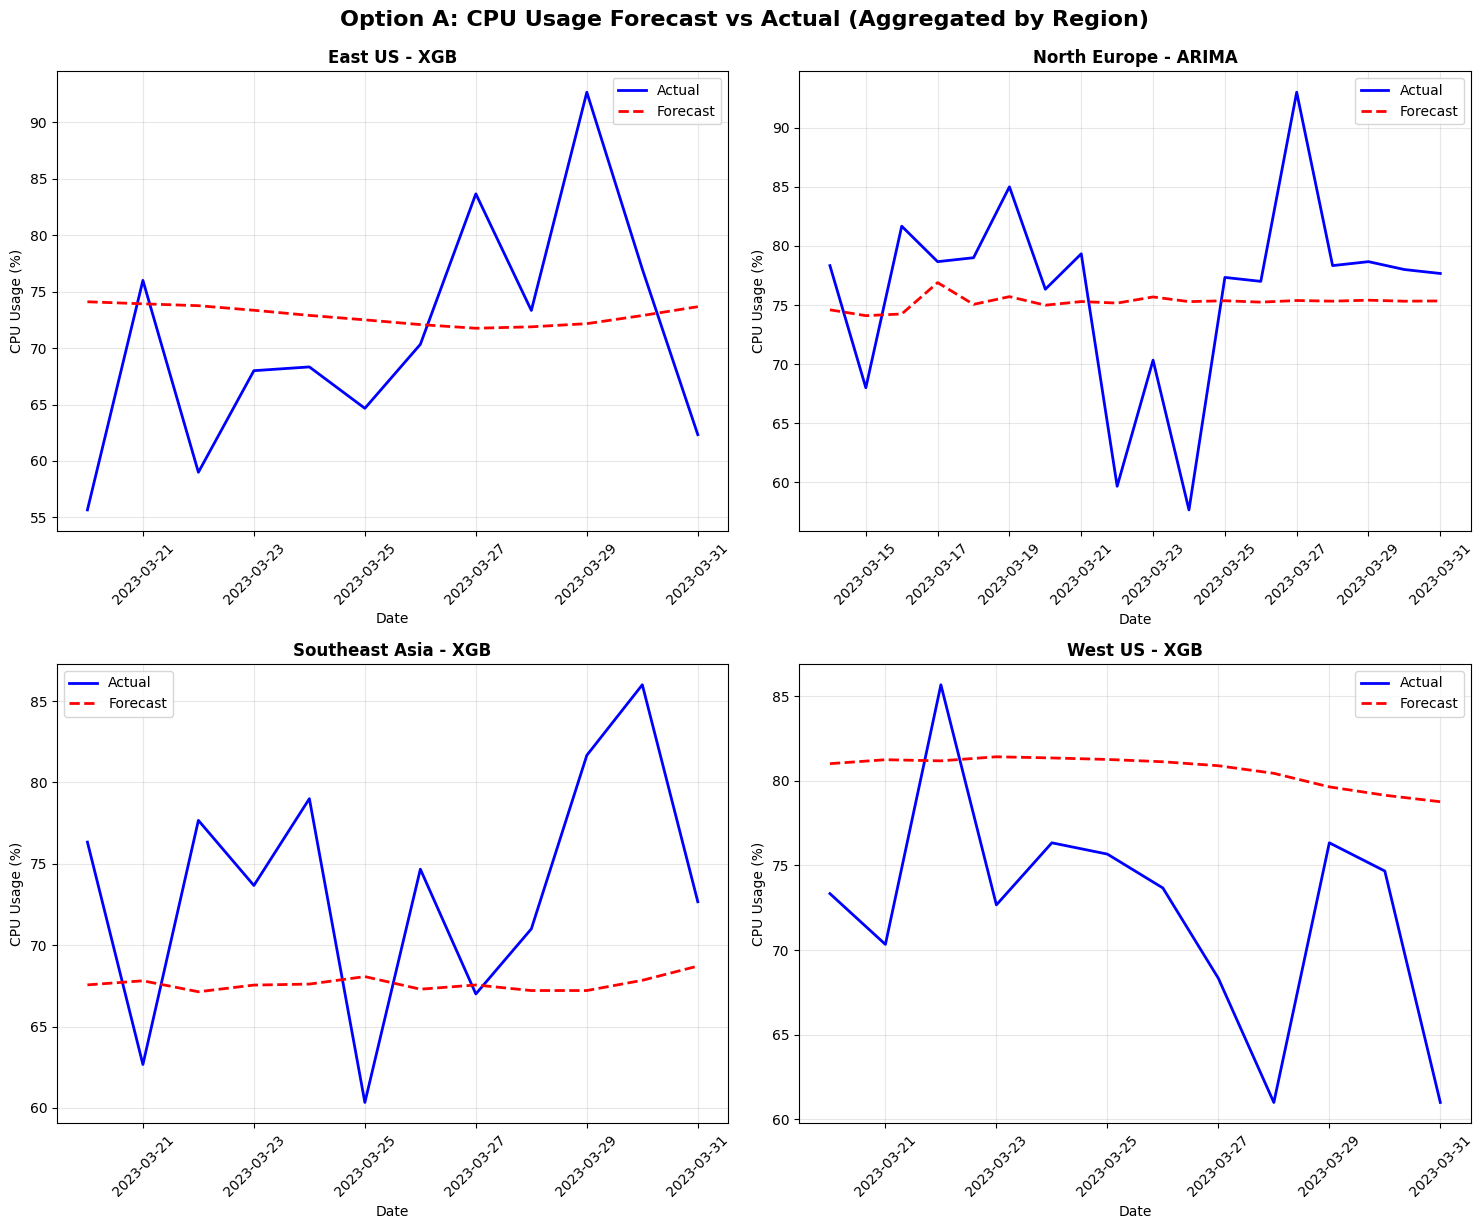


✓ Models saved in: option_A_aggregated_by_region_models
✓ All forecasts use aggregated average CPU usage per region per day


In [7]:
# Cell 6: Save Models for Option A & Visualize Forecast vs Actual (FIXED)
# Automatically select best model per region based on lowest RMSE
import pandas as pd

# Summary metrics as DataFrame
summary = pd.DataFrame({
    'ARIMA_RMSE':   [10.20, 8.02, 7.46, 16.38],
    'XGB_RMSE':     [9.21, 9.04, 6.95, 7.94],
    'LSTM_RMSE':    [10.66, 10.06, 9.27, 10.42]
}, index=['East US', 'North Europe', 'Southeast Asia', 'West US'])

# For each region, pick the model with the minimum RMSE
final_selection = {}
for region, row in summary.iterrows():
    best_model = row[['ARIMA_RMSE','XGB_RMSE','LSTM_RMSE']].idxmin()
    # Strip suffix to get model name
    final_selection[region] = best_model.replace('_RMSE','')

print(final_selection)


# # Define the final selected best model per region
# final_selection = {
#     'East US': 'ARIMA',
#     'North Europe': 'ARIMA', 
#     'Southeast Asia': 'ARIMA',
#     'West US': 'LSTM'
# }

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Create output directory
model_dir = 'option_A_aggregated_by_region_models'
os.makedirs(model_dir, exist_ok=True)

# Helper function to plot forecasts
def plot_forecast(region, dates, actual, forecast, ax):
    ax.plot(dates, actual, label='Actual', color='blue', linewidth=2)
    ax.plot(dates, forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{region} - {final_selection[region]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('CPU Usage (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(15,12))
axes = axes.flatten()

for idx, (region, data) in enumerate(region_dfs.items()):
    print(f"Processing {region}...")
    ts = data['usage_cpu']  # This is the aggregated average CPU usage
    n = len(ts)
    split = int(0.8 * n)

    # 1) ARIMA forecast
    if region == 'East US':
        ts_diff = ts.diff().dropna()
        train_diff = ts_diff.iloc[:split-1]
        model_arima = ARIMA(train_diff, order=(5,0,0)).fit()
        preds_diff = model_arima.forecast(steps=len(ts_diff) - (split-1))
        last_train = ts.iloc[split-1]
        forecast_arima = np.r_[ [last_train], preds_diff ].cumsum()[1:]
    else:
        train_ts = ts.iloc[:split]
        model_arima = ARIMA(train_ts, order=(5,1,0)).fit()
        forecast_arima = model_arima.forecast(steps=n - split)

    # Save ARIMA
    with open(f"{model_dir}/{region.replace(' ','_')}_ARIMA.pkl", 'wb') as f:
        pickle.dump(model_arima, f)

    # 2) XGBoost forecast
    df_xgb = data.copy()
    df_xgb['lag1'] = df_xgb['usage_cpu'].shift(1)
    df_xgb['lag7'] = df_xgb['usage_cpu'].shift(7)
    df_xgb = df_xgb.dropna()
    features = ['lag1','lag7','users_active','economic_index','holiday']
    X = df_xgb[features]; y = df_xgb['usage_cpu']
    split_x = int(0.8 * len(X))
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X.iloc[:split_x], y.iloc[:split_x])
    forecast_xgb = xgb_model.predict(X.iloc[split_x:])
    
    with open(f"{model_dir}/{region.replace(' ','_')}_XGB.pkl", 'wb') as f:
        pickle.dump(xgb_model, f)

    # 3) LSTM forecast
    seq = data[['usage_cpu']].values
    scaler = MinMaxScaler()
    seq_scaled = scaler.fit_transform(seq)
    n_steps = 30
    Xs, ys = [], []
    for i in range(n_steps, len(seq_scaled)):
        Xs.append(seq_scaled[i-n_steps:i,0])
        ys.append(seq_scaled[i,0])
    Xs, ys = np.array(Xs), np.array(ys)
    split_l = int(0.8 * len(Xs))
    X_test_l = Xs[split_l:].reshape(-1, n_steps, 1)
    
    lstm_model = Sequential([
        LSTM(50, input_shape=(n_steps,1)), 
        Dropout(0.2), 
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(Xs[:split_l].reshape(-1,n_steps,1), ys[:split_l],
                   epochs=50, batch_size=16, validation_split=0.2,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
                   verbose=0)
    preds_scaled = lstm_model.predict(X_test_l, verbose=0).flatten()
    forecast_lstm = scaler.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
    
    lstm_model.save(f"{model_dir}/{region.replace(' ','_')}_LSTM.h5")
    with open(f"{model_dir}/{region.replace(' ','_')}_scaler.pkl", 'wb') as f:
        pickle.dump(scaler, f)

    # Select forecast and align dates based on chosen model
    chosen = final_selection[region]
    
    if chosen == 'ARIMA':
        dates = ts.index[split:]
        vals = ts.iloc[split:].values  # Aggregated actual values
        forecast_vals = forecast_arima
    elif chosen == 'XGBoost':
        # XGBoost dates from the filtered dataframe
        dates = df_xgb.index[split_x:]
        vals = ts.loc[dates].values  # Aggregated actual values for those dates
        forecast_vals = forecast_xgb
    else:  # LSTM
        # LSTM dates start from n_steps position in original series
        lstm_test_start = n_steps + split_l  # Actual start position
        end_pos = min(lstm_test_start + len(forecast_lstm), len(ts))
        dates = ts.index[lstm_test_start:end_pos]
        vals = ts.iloc[lstm_test_start:end_pos].values  # Aggregated actual values
        forecast_vals = forecast_lstm[:len(dates)]  # Truncate if needed

    print(f"  {region}: {len(dates)} dates, {len(vals)} actual values, {len(forecast_vals)} forecasts")
    
    # Plot with matched lengths
    plot_forecast(region, dates, vals, forecast_vals, axes[idx])

plt.tight_layout()
plt.suptitle('Option A: CPU Usage Forecast vs Actual (Aggregated by Region)', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"\n✓ Models saved in: {model_dir}")
print("✓ All forecasts use aggregated average CPU usage per region per day")
